In [575]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import *

In [576]:
class ScratchKMeans():
    """
    K-meansのスクラッチ実装
    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, n_clusters, n_init, max_iter = 10):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        
        self.sse = 0
        self.center_points = [[]]

    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        
        # 【問題6】異なる初期値で計算
        # 学習回数だけ繰り返す
        for i in range(self.n_init):
            
            # ランダムな初期値から学習を行い、新たなSSE・中心点を取得
            sse, center_points = self.learn(X)
            
            # 初回またはSSEが最小の場合、値を保存
            if i == 0 or sse < self.sse:
                self.sse = sse
                self.center_points = center_points
    
    """
    クラスタの割り当て、中心点の移動、SSEの算出を行い
    新しい中心点とSSEを返却する
    """
    def learn(self, X):
        
        # 【問題1】中心点の初期値を決める（ランダム）
        center_points = self._get_center_points(X)
        
        #  【問題3】クラスタへの割り当て
        X_with_labels = self._do_clustering(X, center_points)
            
        sse = 0
        
        # 【問題5】繰り返し（sseが収束するまで繰り返す）
        i = 0
        while True:
        
            # 【問題4】中心点の移動
            new_center_points = self._move_center_points(X_with_labels)
            # print("    " ,len(new_center_points))
            
            #  【問題3】クラスタへの割り当て
            X_with_labels = self._do_clustering(X, new_center_points)
            
            # 【問題2】SSEを求める関数の作成
            new_sse = self._calc_sse(X_with_labels, new_center_points)
            
            # SSEの値が収束した場合はループを抜ける
            if sse == new_sse or i == self.max_iter:
                # print("   ",i,"回目：",sse)
                break
            # 上記以外の場合はループを続ける
            else:
                center_points = new_center_points
                sse = new_sse
                i +=1
                # print("   ",i,"回目：",sse)
                
        return new_sse, new_center_points
    
    """
    Xの中からランダムな重心を決定するメソッド
    """
    def _get_center_points(self, X):
        
        center_points = [[]]
        
        # クラスタの数だけループ
        for i in range (self.n_clusters):
            # Xの中からランダムな値を中心点とし、リストに格納していく
            center_point = X[ randint( 0, len(X)) ]
            center_points = np.append(center_points, center_point)
        
        # 後続処理のためリシェイプ
        center_points = center_points.reshape( self.n_clusters, X.shape[1])
        
        # shape (クラスタ数, 特徴量)
        return center_points
    
    """
    最も近い中心点にラベルを振り分けるメソッド
    """
    def _do_clustering(self, X, center_points):
        
        distances = np.zeros((len(X), len(center_points)))
        
        # 中心点の個数だけループ
        for i in range( len(center_points) ):
            
            # Xのサンプル数分ループ
            for j in range( len(X) ):
                
                # 中心点との差分を算出
                deff = center_points[i] - X[j]
                
                # 原点から差分の距離を算出し、変数に格納していく
                distances[j][i] = np.linalg.norm(deff)
                # print(distances[j][i])
        
        # それぞれの値から最も距離が短い中心点をその値のラベルとし、ラベルのリストを作成
        labels = np.argmin(distances, axis=1)
        
        # Xとラベルを結合
        X_with_label = np.hstack([X,labels[:,np.newaxis]])
        
        # shape (サンプル数, 特徴量＋1)
        return X_with_label
    
    """
    中心点を移動するメソッド
    """
    def _move_center_points(self, X_with_label):
        
        n_features = X_with_label.shape[1]-1
        
        # 中心点
        center_points = np.zeros((self.n_clusters, n_features ))
        
        all_labels = X_with_label[:,n_features]
        
        # クラス数の数だけループ
        for i in range(self.n_clusters):
            
            # ラベル＝i の行を抽出
            X = X_with_label[np.where(all_labels == i)]
            # ラベルの列を削除
            X = np.delete(X, n_features, 1)
            # 平均を算出し、変数に格納
            X_mean = np.mean(X, axis=0)
            center_points[i] = X_mean
            
        return center_points
    
    """
    sseを計算するメソッド
    """
    def _calc_sse(self, X_with_label, center_points):
        
        sse = 0
        n_features = X_with_label.shape[1]-1
        all_labels = X_with_label[:,n_features]
        
        # クラス数の数だけループ
        for i in range(self.n_clusters):
            
            # ラベル＝i の行を抽出
            X = X_with_label[np.where(all_labels == i)]
            # ラベルの列を削除
            X = np.delete(X, n_features, 1)
            
            # サンプル数分ループ
            for j in range(X.shape[0]):
                
                # 中心点との差分を算出
                deff = X[j] - center_points[i]
                # ノルムを算出し、sseに足していく
                sse += np.linalg.norm(deff)
        return sse
    
    def plot(self, X, labels, no_cp = False):
        
        if no_cp:
            
            cmap = plt.get_cmap("tab10")
            labels_val = labels.unique()
            
            for i in range (len(labels_val)):
                X_n = X[np.where(labels == labels_val[i])]
                for j in range(len(X_n)):
                    plt.scatter(X_n[j, 0], X_n[j, 1], color=cmap(i), edgecolors=cmap(i))
        else:
            self._plot(X, labels, self.center_points)
    
    def _plot(self, X, labels, center_points):
        cmap = plt.get_cmap("tab10")
        
        for i in range (self.n_clusters):
            X_n = X[np.where(labels == i)]
            center_point = center_points[i]
            
            for j in range(len(X_n)):
                plt.scatter(X_n[j, 0], X_n[j, 1], color=cmap(i), edgecolors=cmap(i))
            plt.scatter(center_point[0], center_point[1], color=cmap(i), marker="*",linewidths="1",edgecolors="black", s=150)
    
    """
    【問題8】エルボー法の実装
    """
    def plot_by_elbow(self, X, n):
        
        clusters_list = np.zeros(n)
        sse_list = np.zeros(n)
        k = 2 # クラスタ数初期値
        
        for i in range(n):
            n_clusters = k + i # クラスタ数
            scr_km = ScratchKMeans(n_clusters, self.n_init) # インスタンス生成
            scr_km.fit(X) # 学習
            
            clusters_list[i] = n_clusters
            sse_list[i] = scr_km.sse
        
        plt.plot(clusters_list, sse_list)
    
    """
    入力されたデータがどのクラスタに属するかを計算
    """
    def predict(self, X):
        
        X_with_label = self._do_clustering(X, self.center_points)
        labels = X_with_label[:,X.shape[1]]
        
        return labels

   X.shape: (100, 2)


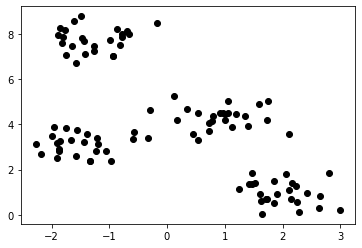

In [577]:
# シンプルデータセット3
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

# データの確認
print("   X.shape:",X.shape)
for i in range(len(X)):
    plt.scatter(X[i, 0], X[i, 1], c='black')

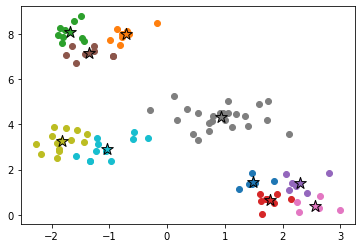

In [578]:
# スクラッチ実装したKMeansを動かす
n_clusters = 10 # クラスタ数
n_init = 50 # 中心点の初期値を何回変えて計算するか

scr_km = ScratchKMeans(n_clusters, n_init) # インスタンス生成
scr_km.fit(X) # 学習
scr_pred = scr_km.predict(X) # 推定
scr_km.plot(X, scr_pred) # 結果の表示


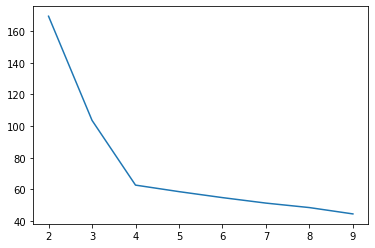

In [579]:
# 【問題8】エルボー法の実装

# エルボー法にて最適なクラスタ数を求める
scr_km.plot_by_elbow(X, 10)

/Users/satouwataru/.pyenv/versions/anaconda3-2020.07/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/satouwataru/.pyenv/versions/anaconda3-2020.07/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


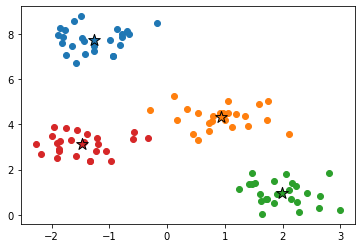

In [580]:
# スクラッチ実装したKMeansを動かす（エルボー法にて得たクラスタ数）
n_clusters = 4 # クラスタ数
n_init = 50 # 中心点の初期値を何回変えて計算するか

scr_km = ScratchKMeans(n_clusters, n_init) # インスタンス生成
scr_km.fit(X) # 学習
scr_pred = scr_km.predict(X) # 推定
scr_km.plot(X, scr_pred) # 結果の表示

***3.クラスタ分析***

In [581]:
# データセットの読み込み
csv_path = "../../../input/Wholesale_customers_DataSet/Wholesale customers data.csv" # ファイル名（パス）を指定する

data = pd.read_csv(csv_path)
data_Region = data["Region"]
data_Channel = data["Channel"]
data = data.drop('Region', axis=1)
data = data.drop('Channel', axis=1)
data

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125


In [582]:
# 《PCAのサンプルコード》
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)
data_pca

array([[ 6.50022122e+02,  1.58551909e+03],
       [-4.42680498e+03,  4.04245151e+03],
       [-4.84199871e+03,  2.57876218e+03],
       [ 9.90346437e+02, -6.27980600e+03],
       [ 1.06579987e+04, -2.15972582e+03],
       [-2.76596159e+03, -9.59870727e+02],
       [-7.15550892e+02, -2.01300227e+03],
       [-4.47458367e+03,  1.42949697e+03],
       [-6.71209540e+03, -2.20590916e+03],
       [-4.82363435e+03,  1.34805592e+04],
       [-7.97482898e+03,  5.71121893e+03],
       [ 3.63937790e+01, -6.03789641e+03],
       [ 1.99402021e+04,  4.59128648e+03],
       [ 9.39669558e+03,  5.91315704e+03],
       [ 1.26603704e+04,  4.54194543e+03],
       [-2.99772590e+03, -6.09387930e+03],
       [-1.05895236e+04,  6.58421594e+03],
       [-6.36709518e+03, -3.68071267e+03],
       [ 6.62382534e+03,  1.25471953e+03],
       [-4.86153157e+03, -2.25592266e+02],
       [ 4.79424416e+03, -3.98879936e+03],
       [-7.24486684e+03, -7.34772325e+03],
       [ 1.92992657e+04, -6.93681068e+03],
       [ 1.

[0.45961362 0.86478588 0.93481597 0.97883941 0.99386152 1.        ]


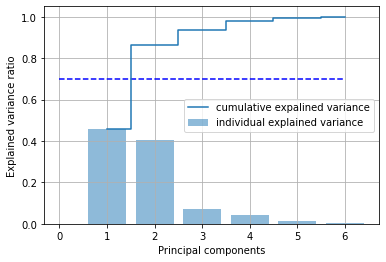

In [583]:
# 《PCAの分散説明率を表示するコードサンプル》
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

/Users/satouwataru/.pyenv/versions/anaconda3-2020.07/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/satouwataru/.pyenv/versions/anaconda3-2020.07/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


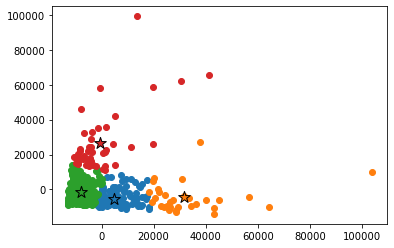

In [584]:
# 【問題10】クラスタ数kの選択
# スクラッチ実装したKMeansを動かす
n_clusters = 4 # クラスタ数
n_init = 50 # 中心点の初期値を何回変えて計算するか

scr_km = ScratchKMeans(n_clusters, n_init) # インスタンス生成

scr_km.fit(data_pca) # 学習
scr_pred = scr_km.predict(data_pca) # 推定
scr_km.plot(data_pca, scr_pred) # 結果の表示


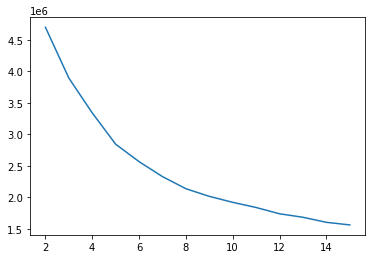

In [585]:
scr_km.plot_by_elbow(data_pca, 15)


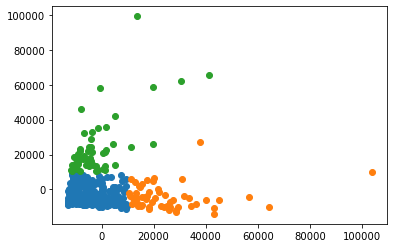

In [586]:
# 【問題11】既知のグループとの比較
n_clusters = 3 # クラスタ数
n_init = 50 # 中心点の初期値を何回変えて計算するか

scr_km = ScratchKMeans(n_clusters, n_init) # インスタンス生成
scr_km.fit(data_pca) # 学習
scr_pred = scr_km.predict(data_pca) # 推定
scr_pred = pd.Series(scr_pred)
scr_km.plot(data_pca, scr_pred, True) # 結果の表示

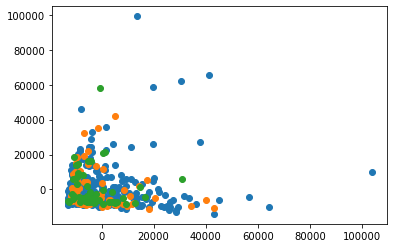

In [587]:
scr_km.plot(data_pca, data_Region, True) # Region

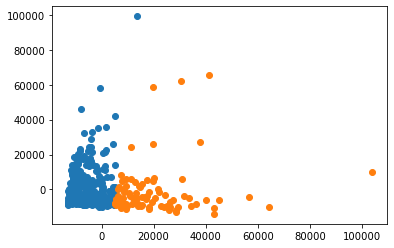

In [588]:
# 【問題11】既知のグループとの比較
n_clusters = 2 # クラスタ数
n_init = 50 # 中心点の初期値を何回変えて計算するか

scr_km = ScratchKMeans(n_clusters, n_init) # インスタンス生成
scr_km.fit(data_pca) # 学習
scr_pred = scr_km.predict(data_pca) # 推定
scr_pred = pd.Series(scr_pred)
scr_km.plot(data_pca, scr_pred, True) # 結果の表示

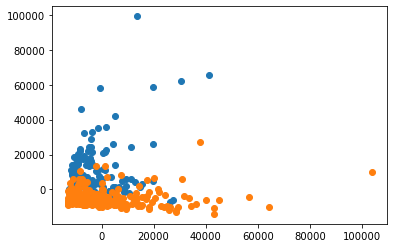

In [589]:
scr_km.plot(data_pca, data_Channel, True) # Channel

**【問題12】卸売業者にとって有益な情報**

次元削減を行ったデータをクラス数２で分割した結果、元々の"Channel"でのクラスタリングと似た結果となった。
（顧客を小売と法人にクラス分けしている）

しかし、全く同じではなく若干の差異が生じている。

その顧客に対し、新たな商品の宣伝を行うと良いのではないか。

例：
K-meansでのクラスが小売になっている法人の顧客に対し、法人の顧客が良く購入している商品を進める等　
